# fontvolve: Generic algorithm to evolve a letter outline

The outline of the letter is encoded into a gene as a sequence of angles and distances, just like how [Logo](https://en.wikipedia.org/wiki/Logo_(programming_language) instructions code the movement of a turtle.  The fitness function compares the drawn letter with the true letter, xor-ing the images and counting the black pixels representing a match.

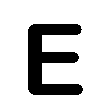

In [5]:
from PIL import Image, ImageFont, ImageDraw, ImageChops
size = 100
black_and_white_format = '1'
gene_image = Image.new(black_and_white_format, (size,size), 0)
letter_image = Image.new(black_and_white_format, (size,size), 1)
usr_font = ImageFont.truetype("ARLRDBD.TTF", size)
drawing = ImageDraw.Draw(letter_image)
drawing.text((20,0), "E", fill=0, font=usr_font)
letter_image


In [6]:
import math

def draw(gene):
    drawing = ImageDraw.Draw(gene_image) #to draw on an image
    drawing.rectangle((0,0,size,size), "white")
    coords = []
    x,y = (size/2,size/2)
    degreeToRadians = 360/(2*math.pi)
    for (angle, dist) in gene:
        x+=dist*math.sin(angle/degreeToRadians)
        y+=dist*math.cos(angle/degreeToRadians)
        coords.append((x,y))
    #print(coords)
    drawing.polygon(coords, fill="black")
    return gene_image

#fitness function: calculate a percentage of image matching the letter, with a small correction to favour shorter genes
def match_letter(gene):
    return float(ImageChops.logical_xor(draw(gene), letter_image).histogram()[0]-5*len(gene))/size/size

def draw_all(gene_pool):
    image = Image.new("1", (size*10,size*10), 1)
    for i in range(0,10):
        for j in range(0,10):
            image.paste(draw(gene_pool[i*10+j]), (j*size, i*size))
            #image.paste(ImageChops.logical_xor(draw(gene_pool[i*10+j]), letter_image), (i*size, j*size))
    return image


In [7]:
from random import random, randint, choice, seed

def mutate(gene):
    new_gene = []
    variation = 2
    for pair in gene:
        rand = random()
        if rand<0.1: #add pair
            new_gene.append((pair[0]+randint(-20,20), pair[1]/2))
            new_gene.append((pair[0]+randint(-20,20), pair[1]/2))
        elif rand<0.2: #remove gene
            None
        elif rand<0.6: #mutate angle 
            new_gene.append( (pair[0]+randint(-20,20), pair[1]) )
        else: #mutate distance
            new_gene.append( (pair[0], pair[1]+randint(-variation,variation)) )
    return new_gene if len(new_gene)>=2 else gene

#combine random part of gene1 with random part of gene2 in random order
def combine(gene1, gene2):
    if random()<0.5:
        return gene1[:randint(2,len(gene1))] + gene2[randint(0,len(gene2)):]
    else:
        return gene2[:randint(2,len(gene2))] + gene1[randint(0,len(gene1)):]

from heapq import nlargest

def evolve(gene_pool):
    indices = range(0,len(gene_pool))
    scores = [match_letter(gene) for gene in gene_pool]
    mutate_fraction = 0.1
    largest = nlargest(max(int(len(gene_pool)*mutate_fraction),1), indices, key=lambda i: scores[i])
    #print([scores[large] for large in largest])
    new_genes = [gene_pool[n] for n in nlargest(2, indices, key=lambda i: scores[i])]
    for large in largest:
        #print(match_letter(gene_pool[large]), gene_pool[large])
        new_genes.append(gene_pool[large])
        mutated = mutate(gene_pool[large])
        #print(match_letter(mutated), mutated)
        new_genes.append(mutated)
    while len(new_genes)<len(gene_pool):
        new_genes.append(combine(gene_pool[choice(largest)],choice(gene_pool)))
        
    return new_genes

In [8]:
pool_size = 200
seed(1)
gene_pool = [[(randint(-90,90), randint(0,size/2)) for pairs in range(0, randint(3,20))] for genes in range(0,pool_size)]
orig_pool = gene_pool

0.9242


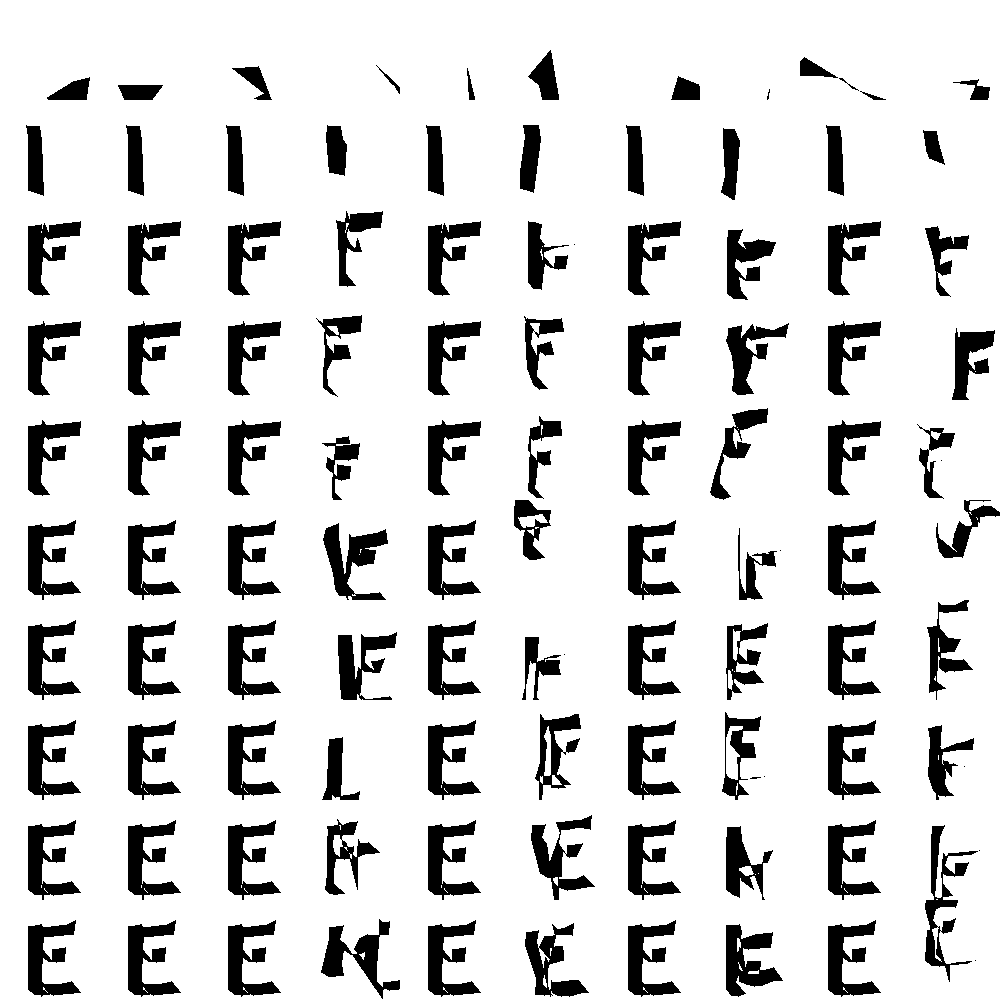

In [9]:
generations= gene_pool[0:10]
for gen in range(0,10):
    for i in range(0,300):
        #print(gene_pool[0])
        gene_pool = evolve(gene_pool)
    generations += gene_pool[0:10]
    
#print(orig_pool[0])
print(match_letter(gene_pool[0]))
#ImageChops.logical_xor(draw(gene_pool[0]), letter_image)
#draw(gene_pool[0])

draw_all(generations)

# Sample evolved fonts
![A](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/fontvolve/fontA.png)
![B](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/fontvolve/fontB.png)
![S](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/fontvolve/fontS.png) (not very well matched - I think needed to rerun a few times to get a good starting point for it to work.)